### EE610: Image Processing
#### Assignment - 3:  Wavelets and Image Restoration
#### - Shrey Patel(19D100020)
#### - Neeraj Patidar(19D070039)

In [ ]:
##adding libraries
import numpy as np
import scipy
import pywt
from PIL import Image as PIL_Image
from scipy.ndimage import gaussian_filter
import matplotlib as mpl
import matplotlib.pyplot as plt
import cv2 as cv
from google.colab.patches import cv2_imshow

##### 1.  Write the following basic functions using numpy and scipy signal libraries only in an efficient manner:
>a. Add additive white Gaussian noise (AWGN) with variable variance to any given image, whether grayscale or color. The noise should be independent in RGB channels for color images.[1]

>b. Measure PSNR (with 255 as the default peak, but it should also be variable) between a restoredimage and a ground-truth image. Do not import a PSNR function directly, even if available.[2]

>c. Measure SSIM (with power 1 for all three elements -- mean, variance, correlation -- which can bevaried too) between a restored and a ground-truth image. Do not import an SSIM function directly,even if available.[3]

>d. Isotropic Gaussian blurring (Gaussian low pass filtering) of an image for a given variance.[4]

In [ ]:

### a. Add additive white Gaussian noise (AWGN) with variable variance to any given image,
###    whether grayscale or color. The noise should be independent in RGB channels for color images.
def awgn(image,variance):
  image = np.array(image, dtype=np.float32)                       #converting to float representation for mathematical operations
  dim = image.shape                                               #dimensions of image
  noise = np.sqrt(variance)*np.random.normal(0,1,dim)             #gaussian noise(since of shape dimensions of image, color image will have independent noise for RGB channels)
  image = np.round(image + noise,0)                               #rounding off to nearest integer
  return np.array(np.clip(image,0,255), dtype=np.uint8)           #returning the value after clipping values between 0-255 and converting the image to 8-bit integer representation

In [ ]:
### b. Measure PSNR (with 255 as the default peak, but it should also be variable) between a restoredimage and a ground-truth image.
###    Do not import a PSNR function directly, even if available.
def PSNR(groundTruthImage,restoredImage,peak=255):                     ### default peak = 255
  groundTruthImage = np.array(groundTruthImage,dtype=np.float32)       ### converting originalimage to np.array and float32
  restoredImage = np.array(restoredImage,dtype=np.float32)             ### converting restored image to np.array and float32
  error = np.subtract(restoredImage,groundTruthImage)                  ### element wise difference
  error_sqrd = error*error                                             ### element wise multiplication(squaring each element)
  mse = np.sum(error_sqrd)/(np.size(error_sqrd))                       ### mean squared error
  return 10*np.log10(peak*peak/mse);                                    ### psnr

In [ ]:
### c. Measure SSIM (with power 1 for all three elements -- mean, variance, correlation -- which can bevaried too)
###    between a restored and a ground-truth image.
###    Do not import an SSIM function directly,even if available.
def SSIM(groundTruthImage,restoredImage,alpha=1,beta=1,gamma=1,c = [0.01,0.03,0.015]):    ### included default c=[c1,c2,c3]
                                                                                          ### and powers of l(x,y),c(x,y) and s(x,y),
                                                                                          ### can be varied if needed
  groundTruthImage = np.array(groundTruthImage,dtype=np.float32)
  restoredImage = np.array(restoredImage,dtype=np.float32)
  ux = np.mean(groundTruthImage)                                                          ### mean of image-x
  uy = np.mean(restoredImage)                                                             ### mean of image-y
  sigx = np.sqrt(np.var(groundTruthImage))                                                         ### variance of image-x
  sigy = np.sqrt(np.var(restoredImage))                                                         ### variance of image-y
  sigxy = np.mean(groundTruthImage*restoredImage) - ux*uy                                 ### covariance of images x and y
  l_xy = (2*ux*uy + c[0])/(ux*ux + uy*uy + c[0])                                          ### l(x,y)
  c_xy = (2*sigx*sigy + c[1])/(sigx*sigx + sigy*sigy + c[1])                              ### c(x,y)
  s_xy = (sigxy + c[2])/(sigx*sigy + c[2])                                                ### s(x,y)
  return (l_xy**alpha)*(c_xy**beta)*(s_xy**gamma);                                            ### ssim

In [ ]:
### d. Isotropic Gaussian blurring (Gaussian low pass filtering) of an image for a given variance.
### -----------------Implementation-1: Using inbuilt gaussian filter-------------------
# def IGB(image,variance):
#   image = np.array(image, dtype = np.float32)
#   return gaussian_filter(image,np.sqrt(variance))

# ------------------Implementation-2: Without using inbuilt filter---------------------
### computing gaussian filter of required shape and  variance
def GF(shape,variance):
  H = np.ones(shape,dtype = np.float32)                                                            #define an array of required shape of dtype=float32
  for i in range(shape[0]):
    H[i,:] = (H[i,:])*(np.float_power(np.e,-((i-shape[0]//2)**2/(2*variance))))  #edit ith row with exp(-i*i/(M*M*variance)) and centering the filter
  for j in range(shape[1]):
    H[:,j] = (H[:,j])*(np.float_power(np.e,-((j-shape[1]//2)**2/(2*variance))))  #edit jth column with exp(-j*j/(N*N*variance)) and centering the filter
  return H                                                                                         #editing row and column gives required filter, center at (M//2,N//2)

### filter a single channel, array arguments to these function are float type and it returns the float type array
### shouldn't be used to apply LPF directly on a given image
def filter(image,H):
  dft = cv.dft(np.float32(image),flags = cv.DFT_COMPLEX_OUTPUT)      #2d dft of image
  dft = np.fft.fftshift(dft)                                   #centering the dft(shifting)
  dft_t = dft
  dft[:,:,0] = dft_t[:,:,0]*H
  dft[:,:,1] = dft_t[:,:,1]*H
  dft = np.fft.ifftshift(dft)
  image = cv.idft(dft)/(np.size(H))
  return image[:,:,0]
### this function filters the greyscale as well as color images , for color images same filter is applied to all three channels
def IGB(image,variance):
  image = np.array(image, dtype = np.float32)                                                             #convert to dtype = float32
  shape = image.shape
  if len(shape) == 2:                                                                                     #if image is a greyscale image
    H = GF(shape,variance)                                                                                #then apply filter h on the intensity channel
    filtered_image = np.round(filter(image,H),0)                                                          #update filtered_image
  elif len(shape) == 3 and shape[2]==3:                                                                   #else if image is a color image with rgb channels
    H = GF((shape[0],shape[1]),variance)                                                                  #find filter of size same as resolution of thee image
    filtered_image = 0*image                                                                              #initialize an empty array
    filtered_image[:,:,0] = np.round(filter(image[:,:,0],H),0)                                            #apply filter H to each of R,G,B channels of image independently
    filtered_image[:,:,1] = np.round(filter(image[:,:,1],H),0)
    filtered_image[:,:,2] = np.round(filter(image[:,:,2],H),0)
  else:                                                                                                   #else if dimensions of image not of same type as of
    raise Exception("Image could be a 2-D(greyscale image) or 3-D array(color image with 3 channels).")   #a greyscale image or color image, then raise exception
  return np.array(filtered_image,dtype = np.uint8)                                                        #return the filtered image with appropriate 8-bit integer datatype

##### 2. Write the following denoising functions for wavelet transforms (you can use a library for DWT and IDWT):
>a. Hard thresholding: set to zero any detail (LH, HL, HH) coefficient that is below a threshold (thresholdshould be variable).

>b. Soft threhsolding: set to zero any detail (LH, HL, HH) coefficient that is below a threshold (thresholdshould be variable), and subtract the threshold from those that are above the threshold.

>c. The method proposed in the paper “Image Denoising using Neighbouring Wavelet Coefficients” by Chen et al available at 'https://www.egr.msu.edu/~aviyente/neighshrink.pdf'.

In [ ]:
###  a. Hard thresholding: set to zero any detail (LH, HL, HH) coefficient that is below a
###     threshold (threshold should be variable).

def hardThresholding(data, threshold):
  data = np.asarray(data) # input as array.
  cond = np.less(np.absolute(data), threshold) # check data vs threshold values.
  return np.where(cond, 0, data)  ## if data > threshold -> apply cond and let data remain as is; if data < threshold, make it 0.


def HardDenoise(image, t):   # t is the threshold variable
  image = np.array(image,dtype=np.float32)
  LL, (LH, HL, HH) = pywt.dwt2(image, 'haar')   # using haar window  # coeff = LL, LH, HL, HH
  coeffs = [LL, LH, HL, HH]

  for i in range(1, len(coeffs[1:])):   # from 1 so only detail coeff get thresholded
    coeffs[i] = hardThresholding(coeffs[i], t*np.max(coeffs[i]))   # t*max(coeff[i]) so that threshold is according to the magnitude of coeff.
  # applied hard thresholding
  coeff = coeffs[0], (coeffs[1], coeffs[2], coeffs[3])  # extracting back the coefficients
  denoisedImage = pywt.idwt2((coeff), 'haar')  # idwt
  denoisedImage = np.clip(np.round(denoisedImage),0,255)
  return np.array(denoisedImage,dtype=np.uint8)

In [ ]:
###  b. Soft threhsolding: set to zero any detail (LH, HL, HH) coefficient that is below a threshold (thresholdshould be variable)
###     , and subtract the threshold from those that are above the threshold.


def softThresholding(data, threshold):
  data = np.asarray(data)
  magnitude = np.absolute(data)

  with np.errstate(divide='ignore'):
      # divide by zero allowed as np.inf values get clipped, so ignore warning.
      thresholded = (1 - threshold/magnitude)
      thresholded.clip(min=0, max=None, out=thresholded)  # to limit the values in [0,inf]
      thresholded = data * thresholded
      return thresholded

def SoftDenoise(image, t):
  image = np.array(image,dtype=np.float32)
  LL, (LH, HL, HH) = pywt.dwt2(image, 'haar')   # using haar window  # coeff = LL, LH, HL, HH
  coeffs = [LL, LH, HL, HH]

  for i in range(1, len(coeffs[1:])):   # from 1 so only detail coeff get thresholded
    coeffs[i] = softThresholding(coeffs[i], t*np.max(coeffs[i]))   # t*max(coeff[i]) so that threshold is according to the magnitude of coeff.
  # applied soft thresholding

  coeff = coeffs[0], (coeffs[1], coeffs[2], coeffs[3])  # extracting back the coefficients

  denoisedImage = pywt.idwt2((coeff), 'haar')  # idwt
  denoisedImage = np.clip(np.round(denoisedImage),0,255)
  return np.array(denoisedImage,dtype=np.uint8)

In [ ]:
###  c. The method proposed in the paper “Image Denoising using Neighbouring Wavelet Coefficients” by Chen et al
###     available at 'https://ieeexplore.ieee.org/document/1326408'(use iitb network to access the paper).

def NieghShrink(window, l):                                                     #function to find updated coefficent
  with np.errstate(divide='ignore'):                                            #ignores divide by zero error
    w_sqrd = window*window                                                      #element wise multiplication, thus squaring each element
    sjk2 = np.sum(w_sqrd)                                                       #sum of squared element
    if sjk2 == np.nan: return window[1,1]                                       #if sjk is nan, then no shrinking takes place
    else: return np.clip(window[1,1]*(1 - l*l/sjk2),0,None)                     #returns updated coefficient according to method by Chen et al.

def NeighDenoise(image,sn):                                                     #image array, noise variance as arguements.
  image = np.array(image,dtype=np.float64)                                      #convert to floating pt rep.
  (len,wid) = image.shape                                                       #dimensions of image
  LL, (LH, HL, HH) = pywt.dwt2(image, 'haar')                                   #2D dwt using haar window  # coeff = LL, LH, HL, HH
  coeffs = [LL, LH, HL, HH]
  l = np.sqrt(2*sn*sn*np.log(len*wid))                                          #threshold calculation
  # LH
  LH = cv.copyMakeBorder(LH,1,1,1,1,cv.BORDER_CONSTANT,0)                       #padding 0s for edged and cornered coefficients
  for i in range(1,LH.shape[0]-1):
    for j in range(1,LH.shape[1]-1):
      LH[i,j] = NieghShrink(LH[i-1:i+2,j-1:j+2],l)                              #calculates and update shrinked coefficient
  LH = LH[1:LH.shape[0]-1,1:LH.shape[1]-1]                                      #discarding edged rows and columns(we padded them earlier)
  # HL
  HL = cv.copyMakeBorder(HL,1,1,1,1,cv.BORDER_CONSTANT,0)                       #same process for HL and HH coefficients
  for i in range(1,HL.shape[0]-1):
    for j in range(1,HL.shape[1]-1):
      HL[i,j] = NieghShrink(HL[i-1:i+2,j-1:j+2],l)
  HL = HL[1:HL.shape[0]-1,1:HL.shape[1]-1]
  # HH
  HH = cv.copyMakeBorder(HH,1,1,1,1,cv.BORDER_CONSTANT,0)
  for i in range(1,HH.shape[0]-1):
    for j in range(1,HH.shape[1]-1):
      HH[i,j] = NieghShrink(HH[i-1:i+2,j-1:j+2],l)
  HH = HH[1:HH.shape[0]-1,1:HH.shape[1]-1]

  coeff = LL, (LH, HL, HH)                                                      #extracting back the coefficients
  denoisedImage = pywt.idwt2((coeff), 'haar')                                   #2D-idwt
  denoisedImage = np.clip(np.round(denoisedImage),0,255)                        #rounding off and clipping value between 0 and 255
  return np.array(denoisedImage,dtype=np.uint8)                                 #converting to unsigned 8-bit integer

##### 3. Compare PSNR and SSIM (with plots) when you vary the *noise* added to clean color images by varying:
> a. Noise variance.

>b. Gaussian low pass filtering with various variances.

>c. The two thresholding methods, where threshold is given by λ = $σ$$\sqrt
{2logn^2}$ (as suggested byDonoho et al.), where 𝜎 is noise variance, and 𝑛 is window size.

>d. The method of Chen et al.

>e. When the method is independently applied to RGB channels, versus when the method is applied to Ichannel of HSI transform.

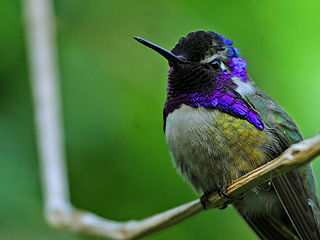

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


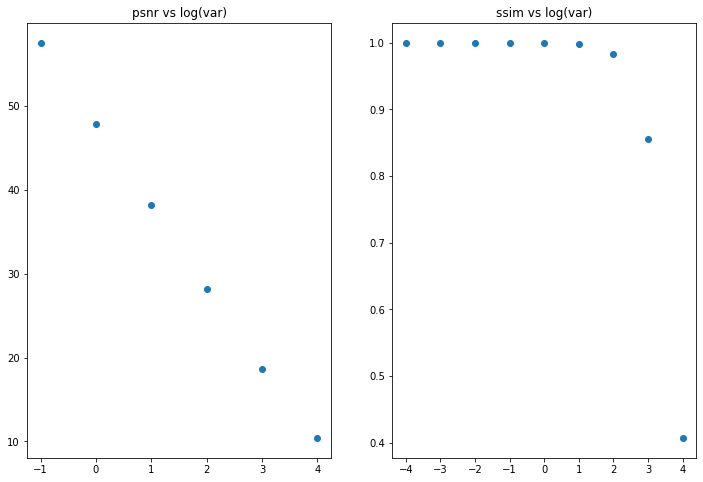

noise variance:  0.0001


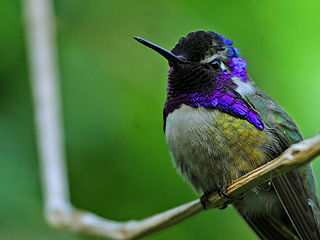

-----------------------------
noise variance:  0.001


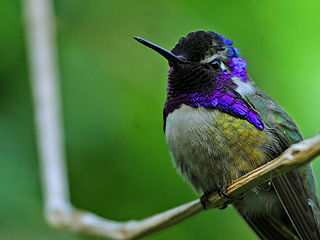

-----------------------------
noise variance:  0.01


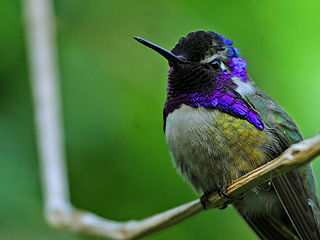

-----------------------------
noise variance:  0.1


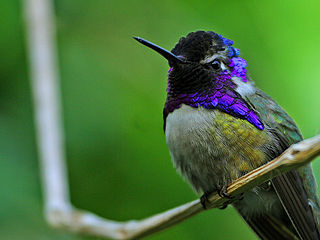

-----------------------------
noise variance:  1.0


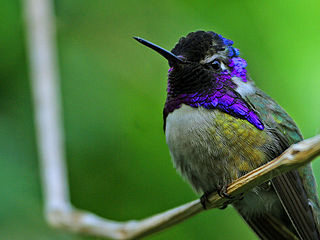

-----------------------------
noise variance:  10.0


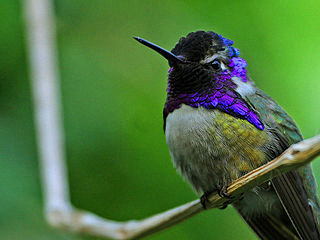

-----------------------------
noise variance:  100.0


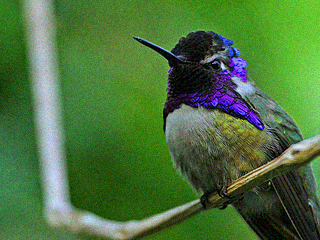

-----------------------------
noise variance:  1000.0


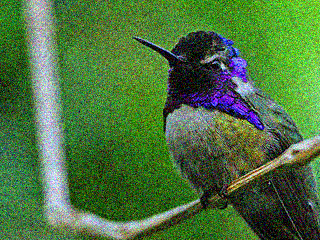

-----------------------------
noise variance:  10000.0


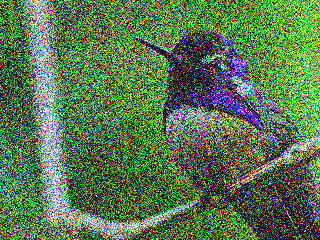

-----------------------------


In [ ]:
### a. Noise Variance
image_3a = cv.imread("/content/hb.jpg")
cv2_imshow(image_3a)
var = np.array([-4,-3,-2,-1,0,1,2,3,4],dtype=np.float32)                        #variable variance array
noisy_images = []                                                               #variable to store noisy images,
psnr = []                                                                       #psnr and
ssim = []                                                                       #ssim
for x in var:                                                                   #iterate over all variances
  noisy = awgn(image_3a,10**x)                                                  #add nosie to image, variance of noise varies in powers of 10
  noisy_images.append(noisy);                                                   #append noisy image
  psnr.append(PSNR(image_3a,noisy));                                            #find psnr and store it
  ssim.append(SSIM(image_3a,noisy));                                            #find ssim
fig,ax = plt.subplots(1,2,False,False,False,figsize=(12,8));                    #plotting results, in log scale
ax[0,0].scatter(var,psnr);
ax[0,1].scatter(var,ssim);
ax[0,0].set_title("psnr vs log(var)");
ax[0,1].set_title("ssim vs log(var)");
plt.show()
for i in range(var.shape[0]):
  print("noise variance: ",10**var[i])
  cv2_imshow(noisy_images[i]);
  print("-----------------------------")

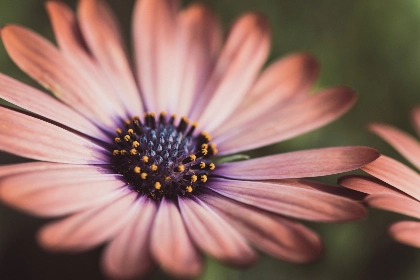

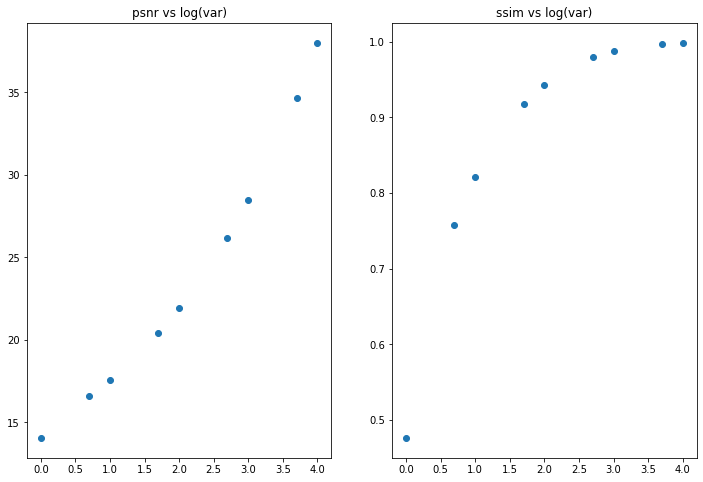

noise variance:  1.0


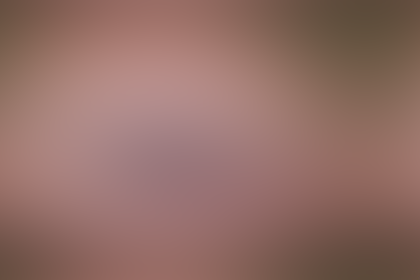

-----------------------------
noise variance:  5.0


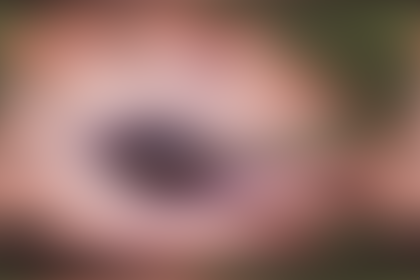

-----------------------------
noise variance:  10.0


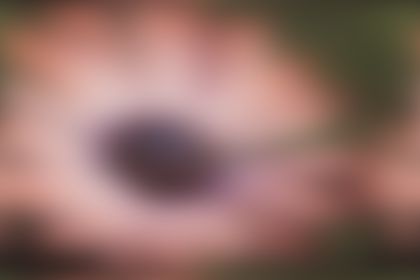

-----------------------------
noise variance:  50.0


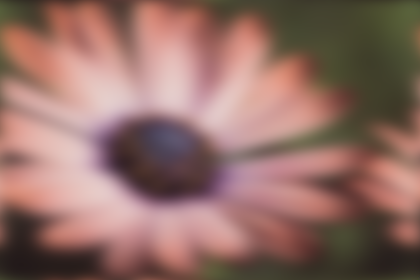

-----------------------------
noise variance:  100.0


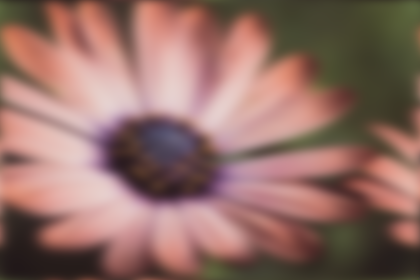

-----------------------------
noise variance:  500.0


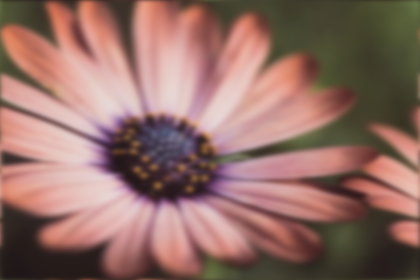

-----------------------------
noise variance:  1000.0


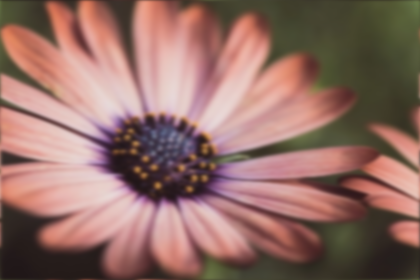

-----------------------------
noise variance:  5000.0


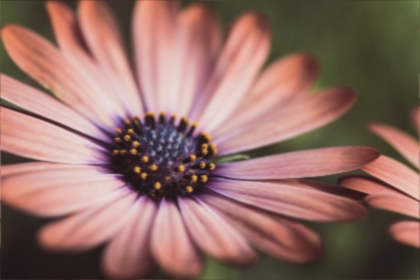

-----------------------------
noise variance:  10000.0


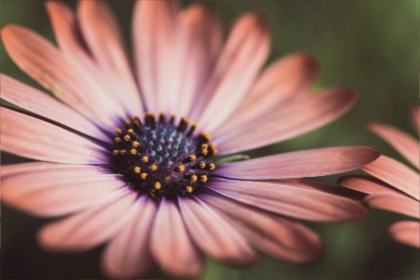

-----------------------------


In [ ]:
### b. BY GLPF
image_3b = cv.imread("/content/3b.webp")
cv2_imshow(image_3b)
var = np.array([1,5,1e1,5e1,1e2,5e2,1e3,5e3,1e4],dtype=np.float32)
noisy_images = []
psnr = []
ssim = []
for x in var:
  noisy = IGB(image_3b,x)                                                       #add noise
  noisy_images.append(noisy);
  psnr.append(PSNR(image_3b,noisy));                                            #find psnr
  ssim.append(SSIM(image_3b,noisy));                                            #find ssim
fig,ax = plt.subplots(1,2,False,False,False,figsize=(12,8));                    #plotting results, in log scale
ax[0,0].scatter(np.log10(var),psnr);
ax[0,1].scatter(np.log10(var),ssim);
ax[0,0].set_title("psnr vs log(var)");
ax[0,1].set_title("ssim vs log(var)");
plt.show()
for i in range(var.shape[0]):
  print("noise variance: ",var[i])
  cv2_imshow(noisy_images[i]);
  print("-----------------------------")

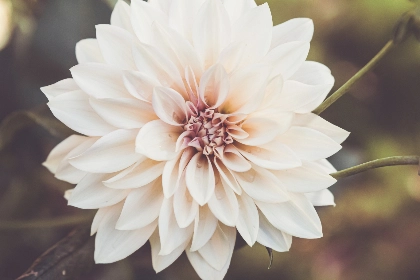

Image after adding Noise


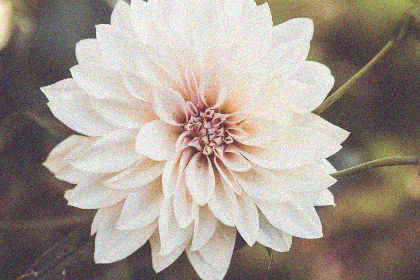

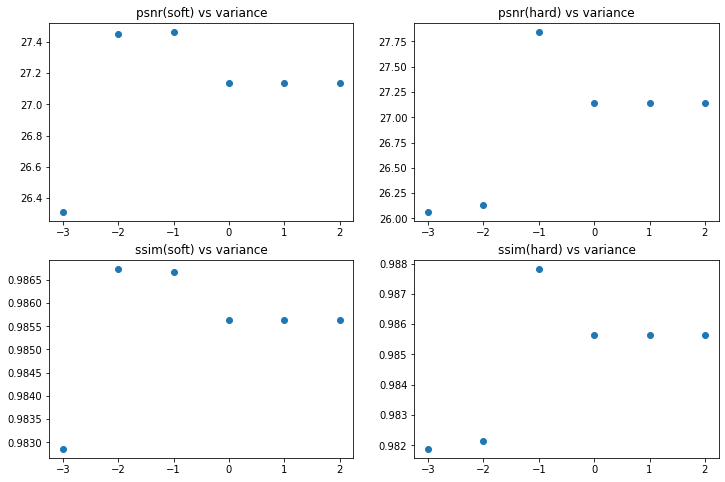

Noisy Image PSNR:  26.067216877921137
Noisy Image SSIM:  0.9818829587116528


In [ ]:
### c. Two methods proposed by Donoho et al

# function to Soft denoise color images and find psnr,
# by applying soft denoising for RGB channels independently
def PSNRSoft(image,noisy_image,t):
  denoised = image.copy()
  denoised[:,:,0] = SoftDenoise(noisy_image[:,:,0],t)
  denoised[:,:,1] = SoftDenoise(noisy_image[:,:,1],t)
  denoised[:,:,2] = SoftDenoise(noisy_image[:,:,2],t)
  return PSNR(image,denoised)

# function to Soft denoise color images and find psnr,
# by applying soft denoising for RGB channels independently
def PSNRHard(image,noisy_image,t):
  denoised = image.copy()
  denoised[:,:,0] = HardDenoise(noisy_image[:,:,0],t)
  denoised[:,:,1] = HardDenoise(noisy_image[:,:,1],t)
  denoised[:,:,2] = HardDenoise(noisy_image[:,:,2],t)
  return PSNR(image,denoised)

# function to Soft denoise color images and find psnr,
# by applying soft denoising for RGB channels independently
def SSIMSoft(image,noisy_image,t):
  denoised = image.copy()
  denoised[:,:,0] = SoftDenoise(noisy_image[:,:,0],t)
  denoised[:,:,1] = SoftDenoise(noisy_image[:,:,1],t)
  denoised[:,:,2] = SoftDenoise(noisy_image[:,:,2],t)
  return SSIM(image,denoised)

# function to Soft denoise color images and find psnr,
# by applying soft denoising for RGB channels independently
def SSIMHard(image,noisy_image,t):
  denoised = image.copy()
  denoised[:,:,0] = HardDenoise(noisy_image[:,:,0],t)
  denoised[:,:,1] = HardDenoise(noisy_image[:,:,1],t)
  denoised[:,:,2] = HardDenoise(noisy_image[:,:,2],t)
  return SSIM(image,denoised)

if __name__ == "__main__":
  image_3c = cv.imread("/content/3c.webp")
  dim = image_3c.shape
  np.random.seed(1)                                                             #initializing random  seed to generate same noise variance all times,
                                                                                #can be commented if wish to
  noise_var = 100*np.random.normal(0,1)                                         #noise variance to be added
  noisy_image = awgn(image_3c, noise_var)                                       #add noise
  psnr_actual = PSNR(image_3c,noisy_image)                                      #psnr of noisy image
  ssim_actual = SSIM(image_3c,noisy_image)                                      #ssim of noisy image
  var = np.array([1e-3,1e-2,1e-1,1,1e1,1e2], dtype=np.float32)                  #variance varied from 0.001 to 100 in powers of 10
  cv2_imshow(image_3c)
  print("Image after adding Noise")
  cv2_imshow(noisy_image)
  psnr_soft = []
  psnr_hard = []
  ssim_soft = []
  ssim_hard = []
  t = np.sqrt(2*np.log(dim[0]*dim[1]))                                          #threshold for thresholding, note that variance isn't multiplied yet
  for x in var:
    psnr_soft.append(PSNRSoft(image_3c,noisy_image,t*x))                        #calculating PSNR and SSIM for denoised images using
    ssim_soft.append(SSIMSoft(image_3c,noisy_image,t*x))                        #soft denoise and hard denoise methods,
    psnr_hard.append(PSNRHard(image_3c,noisy_image,t*x))                        #t*x is threshold, earlier variance wasn't multiplied with t
    ssim_hard.append(SSIMHard(image_3c,noisy_image,t*x))

  fig,ax = plt.subplots(2,2,False,False,False,figsize = (12,8));                #plotting figures in log-scale
  ax[0,0].scatter(np.log10(var),psnr_soft);
  ax[0,1].scatter(np.log10(var),psnr_hard);
  ax[1,0].scatter(np.log10(var),ssim_soft);
  ax[1,1].scatter(np.log10(var),ssim_hard);
  ax[0,0].set_title("psnr(soft) vs variance");
  ax[0,1].set_title("psnr(hard) vs variance");
  ax[1,0].set_title("ssim(soft) vs variance");
  ax[1,1].set_title("ssim(hard) vs variance");
  plt.show()
  print("Noisy Image PSNR: ",psnr_actual)                                       #printing PSNR of noisy image
  print("Noisy Image SSIM: ",ssim_actual)                                       #printing SSIM of noisy image

a. Varying noise variance from $10^{-4}$ to $10^4$ in orders of 10 and plotting
PSNR, SSIM gives the above plot. Initially PSNR is $∞$(computationally) for first 3 values of variances beacuse variance is so low that hardly any noise is added to the image, and thus MSE is almost 0 resulting in high PSNR. As noise increases,PSNR decreases, as expected, logarithmically. For low noise, SSIM remains one even for variance = 100, aftwerwards it decrease exponentially.

---

b. Increasing the variance of GLPF implies increasing the frequency range and thus lesser noise. Increasing the variance results in increasing PSNR exponentially after certain value its shoots to ∞ as almost all the frequency components will be retained in noisy image and thus MSE → 0. SSIM increases and saturates to 1 when PSNR → $∞$

##### 4. Compare a few of the methods from part 3 on real noisy images, where noise variance is not known, byassuming various values of the noise variance as trial and error.

#### References:

>[1] AWGN Modelling: https://www.gaussianwaves.com/2015/06/how-to-generate-awgn-noise-in-matlaboctave-without-using-in-built-awgn-function/

>[2] PSNR: EE610-Module 4: Image Restoration, Slide 50

>[3] SSIM: EE610-Module 4: Image Restoration, Slide 50

>[4] GLPF: EE610-Module3: Spatial and Frequency Filtering, SLide 81